<a href="https://colab.research.google.com/github/BC-Chang/MPLBM-UT/blob/master/examples/create_2D_training_data_4NN/Feature_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importing libraries and downloading data
%%capture

!pip install git+https://github.com/je-santos/livelossplot

import os
import sys
import random

# Importing the numerical and viz libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing utilities libs 
import glob
from PIL import Image

# Importing the ML libs
import sklearn
import tensorflow as tf
from tensorflow import keras

#Viz libraries
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display

from livelossplot import PlotLossesKeras
from livelossplot.plot_losses  import MatplotlibPlot

!pip install scikit-fmm
import skfmm
import scipy.ndimage as sc
import time

!pip install porespy
import porespy as ps

!pip install eikonalfm
import eikonalfm

import warnings
warnings.simplefilter("ignore")

try:
  os.mkdir('numpys')
except:
  pass 


!git clone https://github.com/je-santos/PoreFlow-Net.git
!mv PoreFlow-Net/ilustrations/numpys.zip numpys/numpys.zip
os.chdir('numpys')


from zipfile import ZipFile
with ZipFile('numpys.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
os.chdir('..')

X = np.load('numpys/X.npy')
y = np.load('numpys/y.npy').astype(np.float32)
print(f'The shape of X is {X.shape} and the shape of y is {y.shape}: (Number of examples, x and y)')
X_mean = np.mean(X, axis=(1,2))
y_mean = np.mean(y, axis=(1,2))*10000 #normalize the data

In [2]:
k   = np.mean(y, axis=(1,2))*100000 #normalize the permeability

# data cleaning (remove non-percolating samples)
def drop_samples(x,ind):
    return x[ind]

indices = np.where(k>0.01) # drop the samples where the permeability is lower than 0.01 [D]
X,y,k   = [drop_samples(array,indices) for array in [X,y,k]]

In [3]:
%%capture

def get_features(X):
  feature_dict = {}
  eucl_dist, thickness, chords_vert, chords_horz = np.zeros_like(X), np.zeros_like(X), np.zeros_like(X), np.zeros_like(X)
  chord_count_vert, chord_count_horz = np.empty((X.shape[0],), dtype=object), np.empty((X.shape[0],), dtype=object)
  for im in range(X.shape[0]):
      bin_im = -X[im] + 1 # Invert pore and grain space
      eucl_dist[im] = sc.distance_transform_edt(bin_im) # Find Euclidean Distance
      thickness[im] = ps.filters.local_thickness(bin_im, mode='hybrid')
      chords_vert[im] = ps.filters.apply_chords(bin_im, trim_edges=False)
      chord_count_vert[im] = ps.metrics.chord_counts(chords_vert[im])
      chords_horz[im] = ps.filters.apply_chords(bin_im, axis=1, trim_edges=False)
      chord_count_horz[im] = ps.metrics.chord_counts(chords_horz[im])

  feature_dict={
      'e_dist':eucl_dist,
      'inscribed_spheres':thickness,
      'chords_vert':chords_vert,
      'chord_count_vert':chord_count_vert,
      'chords_horz':chords_horz,
      'chord_count_horz':chord_count_horz
  }
  return feature_dict
start = time.time()
feature_dict = get_features(X)
stop = time.time()




In [4]:
print(f'Time to get features: {stop-start} seconds')
print(feature_dict.keys())

Time to get features: 156.7862160205841 seconds
dict_keys(['e_dist', 'inscribed_spheres', 'chords_vert', 'chord_count_vert', 'chords_horz', 'chord_count_horz'])


IntSlider(value=417, description='Im number', max=792)

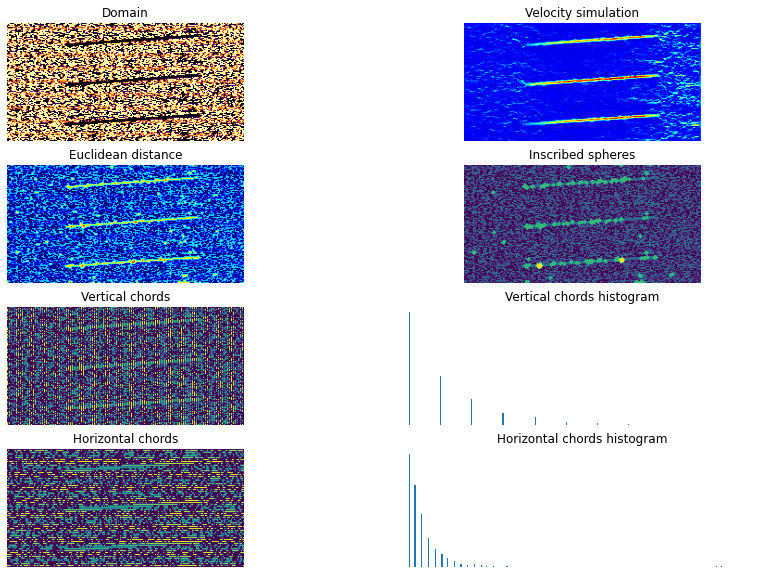

In [5]:
#@title Visualize features with slider

w = widgets.IntSlider()
w.value= 0
w.min =  0
w.max =  X.shape[0]
w.description='Im number'
display(w)

def plot_im(*args):
    clear_output(wait=True)
    display(w)
    
    #plt.figure(dpi=300)
    plt.subplot(4,2,1)
    plt.imshow(X[w.value], cmap=plt.cm.inferno, clim=(0,.75))
    plt.axis('off')
    plt.title('Domain')

    plt.subplot(4,2,2)
    plt.imshow(y[w.value], cmap='jet')
    plt.axis('off')
    plt.title('Velocity simulation')
    
    plt.subplot(4,2,3)
    plt.imshow(feature_dict['e_dist'][w.value], cmap='jet')
    plt.axis('off')
    plt.title('Euclidean distance')

    plt.subplot(4,2,4)
    plt.imshow(feature_dict['inscribed_spheres'][w.value])
    plt.axis('off')
    plt.title('Inscribed spheres')

    plt.subplot(4,2,5)
    plt.imshow(feature_dict['chords_vert'][w.value])
    plt.axis('off')
    plt.title('Vertical chords')
    
    plt.subplot(4,2,6)
    plt.hist(feature_dict['chord_count_vert'][w.value], bins=256)
    plt.axis('off')
    plt.title('Vertical chords histogram')

    plt.subplot(4,2,7)
    plt.imshow(feature_dict['chords_horz'][w.value])
    plt.axis('off')
    plt.title('Horizontal chords')

    plt.subplot(4,2,8)
    plt.hist(feature_dict['chord_count_horz'][w.value], bins=256)
    plt.axis('off')
    plt.title('Horizontal chords histogram')

    fig = plt.gcf() 
    fig.set_size_inches(15,10)
    
plot_im()
w.observe(plot_im,'value')

In [41]:
def plot_stats(stats, k, feature_name):
  for key, value in stats.items():
    plt.figure()
    plt.scatter(value, np.log10(k))
    plt.title(f"Permeability vs. {key+' '+feature_name}")
    plt.ylabel('log10(permeability) [Darcy]')
    plt.xlabel(key+' '+feature_name)
  

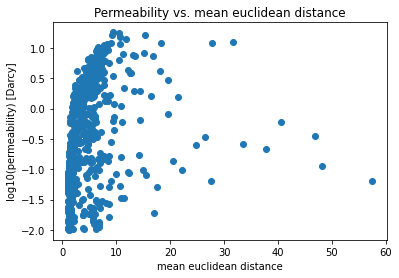

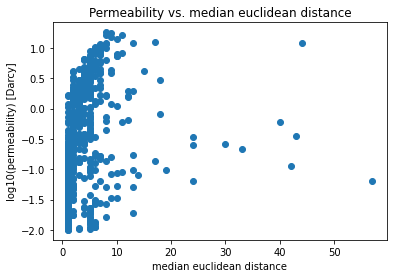

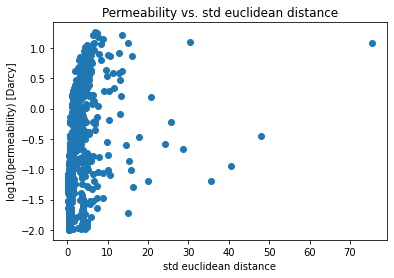

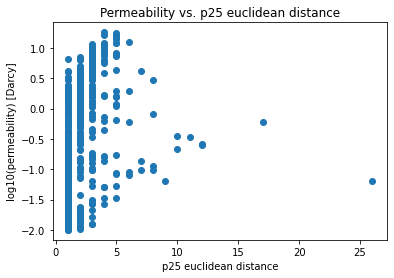

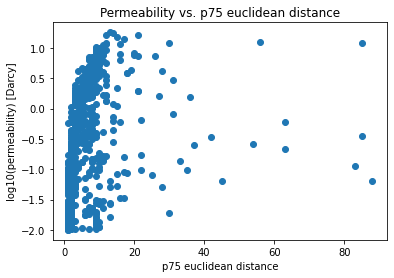

In [42]:
# Get Euclidean Distance statistics
def e_dist_stats(image):
  e_dist_stats = {}
  mean = np.nanmean(image, axis=(1,2))
  median = np.nanmedian(image, axis=(1,2))
  std = np.nanstd(image, axis=(1,2))
  p25 = np.nanquantile(image,.25,axis=(1,2))
  p75 = np.nanquantile(image,.75,axis=(1,2))

  e_dist_stats= {
      'mean':mean,
      'median':median,
      'std':std, 
      'p25':p25,
      'p75':p75
  }
  return e_dist_stats
image = feature_dict['e_dist']
image = np.where(image == 0, np.nan, image)
eucl_dist_stats = e_dist_stats(image)
plot_stats(eucl_dist_stats, k, 'euclidean distance')

In [43]:
# Get horizontal/vertical chord statistics
def get_chord_stats(image):
  chord_stats = {}
  mean = np.zeros_like(image)
  median = np.zeros_like(image)
  std = np.zeros_like(image)
  p25 = np.zeros_like(image)
  p75 = np.zeros_like(image)
  
  for im in range(image.shape[0]):
    mean[im] = np.mean(image[im])
    median[im] = np.median(image[im])
    std[im] = np.std(image[im])
    p25[im] = np.quantile(image[im],.25) 
    p75[im] = np.quantile(image[im],.75)

  chord_stats= {
      'mean':mean,
      'median':median,
      'std':std, 
      'p25':p25,
      'p75':p75
  }
  return chord_stats



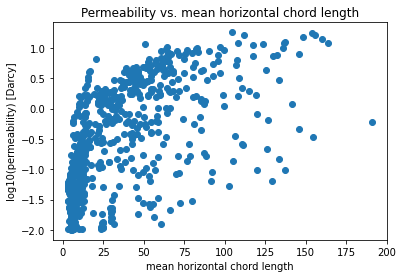

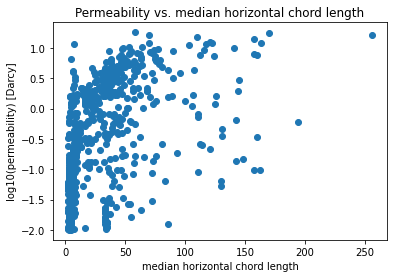

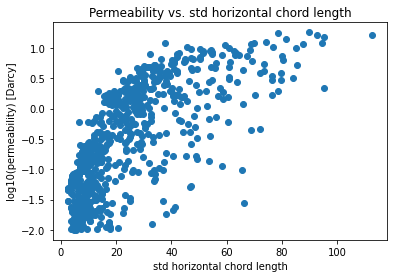

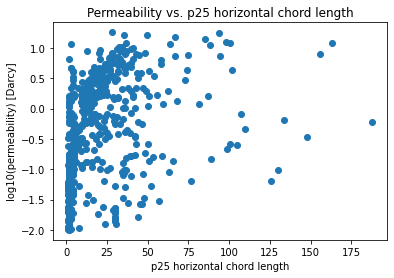

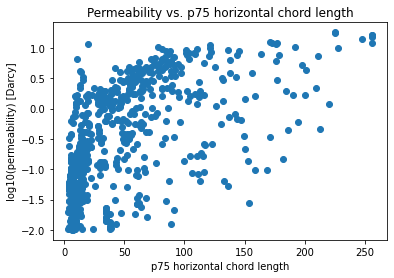

In [44]:
#@title Horizontal Chords
horz_chord_stats = get_chord_stats(feature_dict['chord_count_horz'])
plot_stats(horz_chord_stats, k, 'horizontal chord length')

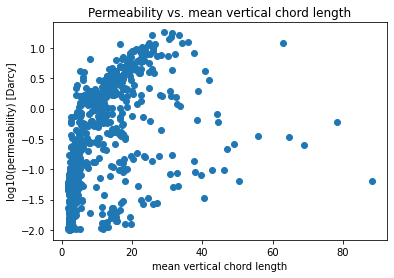

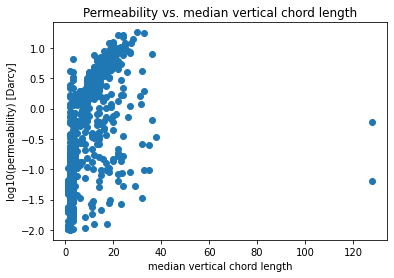

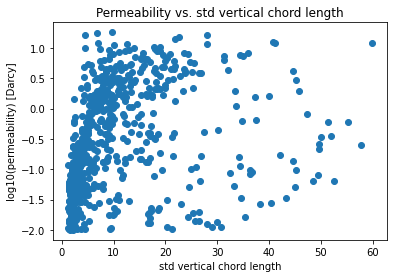

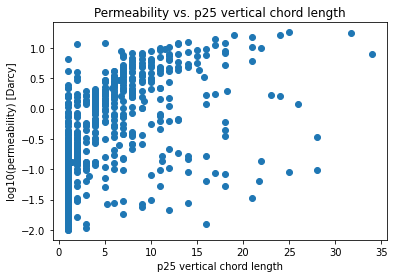

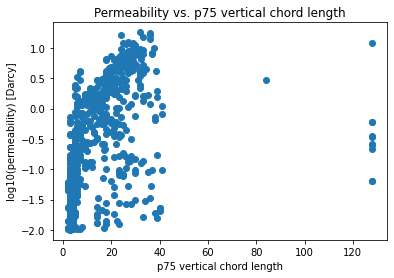

In [45]:
#@title Vertical Chords
vert_chord_stats = get_chord_stats(feature_dict['chord_count_vert'])
plot_stats(vert_chord_stats, k, 'vertical chord length')

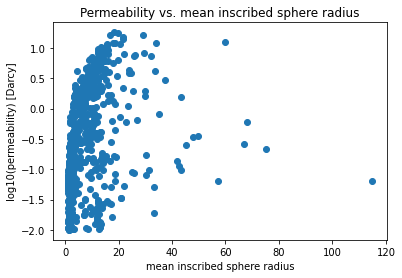

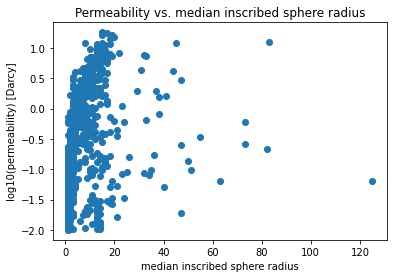

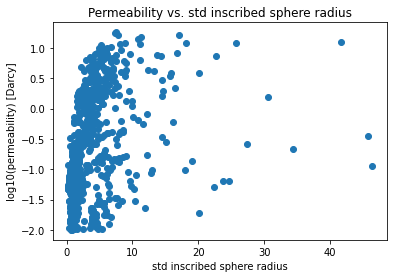

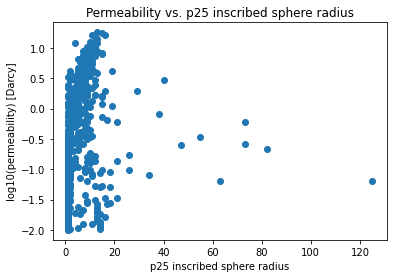

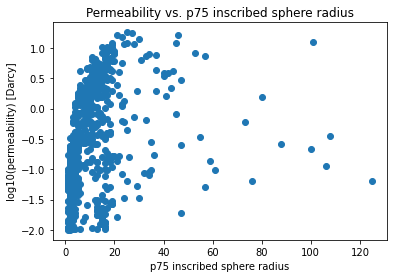

In [46]:
# Get inscribed sphere statistics
def get_thickness_stats(image):
  thk_stats = {}

  mean = np.nanmean(image,axis=(1,2))
  median = np.nanmedian(image,axis=(1,2))
  std = np.nanstd(image,axis=(1,2))
  p25 = np.nanquantile(image, 0.25, axis=(1,2))
  p75 = np.nanquantile(image, 0.75, axis=(1,2))
  
  thk_stats = {
      'mean':mean,
      'median':median,
      'std':std, 
      'p25':p25,
      'p75':p75
  }

  return thk_stats


image = feature_dict['inscribed_spheres']
image = np.where(image<=0, np.nan, image)
thk_stats = get_thickness_stats(image)
plot_stats(thk_stats, k, 'inscribed sphere radius')
